<a href="https://colab.research.google.com/github/Wizcy1121/MLB-home-attendence-prediction/blob/main/MLB_Temporal_Fusion_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_forecasting
!pip install pytorch_lightning
!pip install dill

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.7 MB/s eta 0:00:00


## Import relevant packages

In [ ]:
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import loggers 
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)

torch.cuda.manual_seed(30)
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder,GroupNormalizer
from pytorch_forecasting.data.examples import generate_ar_data
from torchmetrics import TweedieDevianceScore
from pytorch_forecasting.metrics import RMSE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import gc
from tqdm import tqdm
import holidays
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
import dill as pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gl= pd.read_csv("/content/drive/Shareddrives/MinneMUDAC/data/final_gl_Lan.csv")

<ipython-input-6-79e4c5411719>:1: DtypeWarning: Columns (13,15,19,85,87,159,186,193) have mixed types. Specify dtype option on import or set low_memory=False.
  gl= pd.read_csv("/content/drive/Shareddrives/MinneMUDAC/data/final_gl_Lan.csv")


## Prepare for dataset

In [ ]:
gl_model_dataset = gl[['Date',
 'NumberofGames',
 'DayofWeek',
 'VisitingTeam',
 'VisitingTeamLeague',
 'VisitingTeamGameNumber',
 'HomeTeam',
 'HomeTeamLeague',
 'HomeTeamGameNumber',
 'BallParkID',
 'Attendance',
 'year',
 'month',
 'week',
 'is_weekend',
 'opening_day',
 'is_public_holiday',
 'holidayName',
 'HomeTeam_City',
 'HomeTeam_State',
 'VisitingTeam_City',
 'VisitingTeam_State',
 'HomeTeam_ws_winner',
 'VisitingTeam_ws_winner',
 'MVP_in_visitingteam',
 'MVP_in_hometeam',
 'Cy_Young_in_visitingteam',
 'Cy_Young_in_hometeam',
 'id',
 'w_or_l_int',
 'w_l_ratio',
 'div_rank',
 'gb',
 'streak',
 'runs',
 'runs_allowed',
 'last_game_record',
 'last_game_w_l_ratio',
 'last_game_div_rank',
 'last_game_gb',
 'last_game_streak',
 'runs_ma',
 'runs_allowed_ma',
 'last_ten_game_w_l_ratio',
 'season_end_rank',
 'season_end_w_l_ratio',
 'season_end_runs_mean',
 'season_end_runs_allowed_mean',
 'opponent_season_end_rank',
 'opponent_season_end_w_l_ratio',
 'opponent_season_end_runs_mean',
 'opponent_season_end_runs_allowed_mean',
 'NBA_Team',
 'NFL_Team',
 'NHL_Team',
 'bat_avg_age',
 'pitch_avg_age',
 'home_as_cnt',
 'visiting_as_cnt',
 'previous_home_as_cnt',
 'previous_visiting_as_cnt',
 'Capacity',
 'home_pitch10',
 'home_bat10',
 'home_field10',
 'visiting_pitch10',
 'visiting_bat10',
 'visiting_field10',
 'Attendance_1',
 'Attendance_2',
 'Attendance_3',
 'Attendance_4',
 'Attendance_5']]

In [ ]:
tran_df=gl_model_dataset[['Date',
 'NumberofGames',
 'DayofWeek',
 'VisitingTeam',
 'VisitingTeamLeague',
 'VisitingTeamGameNumber',
 'HomeTeam',
 'HomeTeamLeague',
 'HomeTeamGameNumber',
 'BallParkID',
 'Attendance',
 'year',
 'month',
 'week',
 'is_weekend',
 'opening_day',
 'is_public_holiday',
 'holidayName',
 'HomeTeam_City',
 'HomeTeam_State',
 'VisitingTeam_City',
 'VisitingTeam_State',
  'HomeTeam_ws_winner',
   'NBA_Team',
 'NFL_Team',
 'NHL_Team', 
 'VisitingTeam_ws_winner',
 'MVP_in_visitingteam',
 'MVP_in_hometeam',
 'Cy_Young_in_visitingteam',
 'Cy_Young_in_hometeam',
 'season_end_rank',
 'season_end_w_l_ratio',
 'season_end_runs_mean',
 'season_end_runs_allowed_mean',
 'opponent_season_end_rank',
 'opponent_season_end_w_l_ratio',
 'opponent_season_end_runs_mean',
 'opponent_season_end_runs_allowed_mean',
 'home_as_cnt',
 'visiting_as_cnt',
 'previous_home_as_cnt',
 'previous_visiting_as_cnt',
 'Capacity',
 'home_pitch10',
 'home_bat10',
 'home_field10',
 'visiting_pitch10',
 'visiting_bat10',
 'visiting_field10']]

In [ ]:
# create time index for transforming dataset into time series format
tran_df = tran_df.sort_values(["HomeTeam", "Date", "NumberofGames"])
tran_df["date_int"] = tran_df.index+1
tran_df["date_int"] = tran_df.groupby("HomeTeam")["date_int"].rank().apply(int)

In [ ]:
# eliminate NaNs
def handle_nans(df):
    mean_attendance=tran_df_2022.groupby("HomeTeam")['Attendance'].mean().reset_index().rename(columns={'Attendance':"mean_attendance"})
    df=df.merge(mean_attendance,on="HomeTeam")
    df['Attendance']=np.where((df['Attendance'].isna()) |(df['Attendance']== 0),df['mean_attendance'],df['Attendance'])
    
    for f in df.columns:
        if df[f].dtype == "int64" or df[f].dtype == "float64":
            df[f] = df[f].fillna(-1)
        elif df[f].dtype == "object":
            df[f] = df[f].fillna("na")

    return(df)

In [ ]:
tran_df_2022=handle_nans(tran_df_2022)

In [ ]:
# convert relevant features into tft required type
tran_df_2022.DayofWeek = tran_df_2022.DayofWeek.astype(str).astype('category')
tran_df_2022.VisitingTeam = tran_df_2022.VisitingTeam.astype(str).astype('category')
tran_df_2022.VisitingTeamLeague = tran_df_2022.VisitingTeamLeague.astype(str).astype('category')
tran_df_2022.HomeTeam = tran_df_2022.HomeTeam.astype(str).astype('category')
tran_df_2022.HomeTeamLeague = tran_df_2022.HomeTeamLeague.astype(str).astype('category')
tran_df_2022.BallParkID = tran_df_2022.BallParkID.astype(str).astype('category')
tran_df_2022.year = tran_df_2022.year.astype(str).astype('category')
tran_df_2022.month = tran_df_2022.month.astype(str).astype('category')
tran_df_2022.week = tran_df_2022.week.astype(str).astype('category')
tran_df_2022.is_weekend = tran_df_2022.is_weekend.astype(str).astype('category')
tran_df_2022.NBA_Team = tran_df_2022.NBA_Team.astype(str).astype('category')
tran_df_2022.NFL_Team = tran_df_2022.NFL_Team.astype(str).astype('category')
tran_df_2022.NHL_Team = tran_df_2022.NHL_Team.astype(str).astype('category')
tran_df_2022.opening_day = tran_df_2022.opening_day.astype(str).astype('category')
tran_df_2022.is_public_holiday = tran_df_2022.is_public_holiday.astype(str).astype('category')
tran_df_2022.holidayName = tran_df_2022.holidayName.astype(str).astype('category')
tran_df_2022.HomeTeam_City = tran_df_2022.HomeTeam_City.astype(str).astype('category')
tran_df_2022.HomeTeam_State = tran_df_2022.HomeTeam_State.astype(str).astype('category')
tran_df_2022.VisitingTeam_City = tran_df_2022.VisitingTeam_City.astype(str).astype('category')
tran_df_2022.VisitingTeam_State = tran_df_2022.VisitingTeam_State.astype(str).astype('category')
tran_df_2022.HomeTeam_ws_winner = tran_df_2022.HomeTeam_ws_winner.apply(int).astype(str).astype('category')
tran_df_2022.VisitingTeam_ws_winner = tran_df_2022.VisitingTeam_ws_winner.apply(int).astype(str).astype('category')
tran_df_2022.Attendance = tran_df_2022.Attendance.astype(np.float32)
tran_df_2022.MVP_in_hometeam = tran_df_2022.MVP_in_hometeam.apply(int).astype(str).astype('category')
tran_df_2022.MVP_in_visitingteam = tran_df_2022.MVP_in_visitingteam.apply(int).astype(str).astype('category')
tran_df_2022.Cy_Young_in_hometeam = tran_df_2022.Cy_Young_in_hometeam.apply(int).astype(str).astype('category')
tran_df_2022.Cy_Young_in_visitingteam =tran_df_2022.Cy_Young_in_visitingteam.apply(int).astype(str).astype('category')

In [ ]:
train= tran_df_2022[pd.to_datetime(tran_df_2022['Date']).dt.year<2019]
test=tran_df_2022[pd.to_datetime(tran_df_2022['Date']).dt.year==2019]
max_prediction_length = 81
max_encoder_length = 500

# Create Time Series Dataset
training = TimeSeriesDataSet(
    train,
    time_idx="date_int",
    target="Attendance",
    group_ids=["HomeTeam"], 
    min_encoder_length=max_prediction_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["HomeTeam", "HomeTeamLeague",
                          "HomeTeam_City","HomeTeam_State"],
    time_varying_known_categoricals=[ 'DayofWeek', 'year','VisitingTeam', 'VisitingTeamLeague',
                                     'month', 'week','is_weekend',
                                     'opening_day', 'is_public_holiday',
                                      'HomeTeam_ws_winner','VisitingTeam_ws_winner', 'MVP_in_visitingteam',
                                     'MVP_in_hometeam', 'Cy_Young_in_visitingteam',
                                     'Cy_Young_in_hometeam'
                                      ],
    static_reals=['Capacity'],
    #variable_groups={"is_holiday": ["is_holiday"]},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=[ "home_pitch10", "home_bat10",
        "home_field10","visiting_pitch10","visiting_bat10", "visiting_field10",
        'HomeTeam_ws_winner', 'VisitingTeam_ws_winner','Capacity','season_end_rank',
 'season_end_w_l_ratio',
 'season_end_runs_mean',
 'season_end_runs_allowed_mean',
  'opponent_season_end_rank',
 'opponent_season_end_w_l_ratio',
 'opponent_season_end_runs_mean',
 'opponent_season_end_runs_allowed_mean',"VisitingTeamGameNumber","HomeTeamGameNumber"],
    time_varying_unknown_reals=[
        'Attendance'
    ],
    target_normalizer=GroupNormalizer(
        groups=[ "HomeTeam"], transformation="softplus"
    ),  # use softplus and normalize by group

    lags={'Attendance': [1,3,5,7,14]},
    add_encoder_length=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    categorical_encoders={"HomeTeam_ws_winner": NaNLabelEncoder(add_nan=True),
                         "VisitingTeam_ws_winner": NaNLabelEncoder(add_nan=True),
                          'year': NaNLabelEncoder(add_nan=True)
                        
                          }
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


## Build Temporal Fusion Transformer model

In [ ]:

from pytorch_lightning.loggers import TensorBoardLogger

PATIENCE = 30
MAX_EPOCHS = 200
LEARNING_RATE = 0.012067986205675296
OPTUNA = False
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.001, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.47392885281873304,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=17,
    attention_head_size=3,
    dropout=0.12057343228729256,
    hidden_continuous_size=16,
    output_size=1,  # 7 quantiles by default
    loss=MAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 99.6k


In [ ]:
# Fit the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Save best model
model_path = '/content/drive/Shareddrives/MinneMUDAC/Model/tft/tft_model_2022.bin'
pickle.dump(best_tft, open(model_path, 'wb'))

In [ ]:
# best model's training metrics result
model_path = '/content/drive/Shareddrives/MinneMUDAC/Model/tft/tft_model_2022.bin'
best_tft=pickle.load(open(model_path, 'rb'))
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
np.sqrt(((actuals - predictions)**2).mean())
print( 'MAPE:',(np.abs(actuals - predictions)/actuals).mean())
print( 'RMSE:',np.sqrt(((actuals - predictions)**2).mean()))

MAPE: tensor(0.0729)
RMSE: tensor(3021.1316)


In [ ]:
encoder_data[['VisitingTeam',"VisitingTeamLeague"]].drop_duplicates()

,VisitingTeam,VisitingTeamLeague
1206,HOU,AL
1209,SEA,AL
1213,TEX,AL
1216,KCA,AL
1219,OAK,AL
1233,COL,NL
1235,SDN,NL
1238,DET,AL
1242,TBA,AL
1248,ARI,NL


## Generate testing result & save prediction

In [ ]:
model_path = '/content/drive/Shareddrives/MinneMUDAC/Model/tft/tft_model_new_MAPE10.34.bin'
best_tft=pickle.load(open(model_path, 'rb'))
# prepare last_data for prediction


In [ ]:
def testing_MAPE(tft):
  # max_date = train.groupby("HomeTeam")["date_int"].max().reset_index()
  # last_data = max_date.merge(train, on = ["HomeTeam","date_int"], how = "left")

# select last 500 from data (max_encoder_length is 500)
  encoder_data = train.groupby('HomeTeam').tail(500)

  decoder_data = test
# combine encoder and decoder data
  new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

  # raw只返回点, quantiles返回区间估计
  # 'quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]'
  new_raw_predictions, new_x = tft.predict(new_prediction_data, mode="raw", return_x=True)   
  pred=new_raw_predictions[0].numpy().reshape(2430,)
  pred=np.delete(pred,180)
  actual=test['Attendance'].array

  return (np.abs(actual - pred)/actual).mean()

In [ ]:
# testing metrics result
testing_MAPE(best_tft)

/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


0.17994474

In [ ]:
league_maping= encoder_data[['VisitingTeam',"VisitingTeamLeague"]].drop_duplicates()
league_maping

,VisitingTeam,VisitingTeamLeague
1206,HOU,AL
1209,SEA,AL
1213,TEX,AL
1216,KCA,AL
1219,OAK,AL
1233,COL,NL
1235,SDN,NL
1238,DET,AL
1242,TBA,AL
1248,ARI,NL


In [ ]:
prediction=tran_df[tran_df['year']==2023]

prediction = pd.merge(prediction, league_maping,on = "VisitingTeam")
prediction=prediction.drop('VisitingTeamLeague_x',axis=1)

prediction = pd.merge(prediction, league_maping,left_on = "HomeTeam",right_on="VisitingTeam")
prediction=prediction.drop('VisitingTeam_y',axis=1)
prediction=prediction.drop('HomeTeamLeague',axis=1)

In [ ]:
prediction

,Date,NumberofGames,DayofWeek,VisitingTeam_x,VisitingTeamGameNumber,HomeTeam,HomeTeamGameNumber,BallParkID,Attendance,year,...,Capacity,home_pitch10,home_bat10,home_field10,visiting_pitch10,visiting_bat10,visiting_field10,date_int,VisitingTeamLeague_y,VisitingTeamLeague
0,2023-04-07,0.0,4,TOR,NaN,ANA,NaN,ANA01,NaN,2023,...,64573,20,19,17,18,15,14,1703,AL,AL
1,2023-04-08,0.0,5,TOR,NaN,ANA,NaN,ANA01,NaN,2023,...,64573,20,19,17,18,15,14,1704,AL,AL
2,2023-04-09,0.0,6,TOR,NaN,ANA,NaN,ANA01,NaN,2023,...,64573,20,19,17,18,15,14,1705,AL,AL
3,2023-04-10,0.0,0,WAS,NaN,ANA,NaN,ANA01,NaN,2023,...,64573,20,19,17,23,18,16,1706,NL,AL
4,2023-04-11,0.0,1,WAS,NaN,ANA,NaN,ANA01,NaN,2023,...,64573,20,19,17,23,18,16,1707,NL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2023-09-05,0.0,1,NYN,NaN,WAS,NaN,WIL02,NaN,2023,...,2366,23,18,16,16,14,11,1768,NL,NL
2426,2023-09-06,0.0,2,NYN,NaN,WAS,NaN,WIL02,NaN,2023,...,2366,23,18,16,16,14,11,1769,NL,NL
2427,2023-06-19,0.0,0,SLN,NaN,WAS,NaN,WIL02,NaN,2023,...,2366,23,18,16,17,18,17,1736,NL,NL
2428,2023-06-20,0.0,1,SLN,NaN,WAS,NaN,WIL02,NaN,2023,...,2366,23,18,16,17,18,17,1737,NL,NL


In [ ]:
prediction=prediction.rename(columns={"VisitingTeamLeague_x": "VisitingTeamLeague", "VisitingTeamLeague_y": "HomeTeamLeague", "VisitingTeam_x": "VisitingTeam"})

In [ ]:
prediction.DayofWeek = prediction.DayofWeek.astype(str).astype('category')

In [ ]:
def handle_2023_nans(df):
    df['Attendance']=df['Attendance'].fillna(0)
    for f in df.columns:
        if df[f].dtype == "int64" or df[f].dtype == "float64":
            df[f] = df[f].fillna(-1)
        elif df[f].dtype == "object":
            df[f] = df[f].fillna("na")

    return(df)
prediction=handle_2023_nans(prediction)

In [ ]:
prediction.DayofWeek = prediction.DayofWeek.astype(str).astype('category')
prediction.VisitingTeam =prediction.VisitingTeam.astype(str).astype('category')
prediction.VisitingTeamLeague = prediction.VisitingTeamLeague.astype(str).astype('category')
prediction.HomeTeam = prediction.HomeTeam.astype(str).astype('category')
prediction.HomeTeamLeague = prediction.HomeTeamLeague.astype(str).astype('category')
prediction.BallParkID = prediction.BallParkID.astype(str).astype('category')
prediction.year = prediction.year.astype(int)
prediction.month = prediction.month.astype(str).astype('category')
prediction.week = prediction.week.astype(str).astype('category')
prediction.is_weekend = prediction.is_weekend.astype(str).astype('category')
prediction.opening_day = prediction.opening_day.astype(str).astype('category')
prediction.is_public_holiday = prediction.is_public_holiday.astype(str).astype('category')
prediction.holidayName = prediction.holidayName.astype(str).astype('category')
prediction.HomeTeam_City = prediction.HomeTeam_City.astype(str).astype('category')
prediction.HomeTeam_State = prediction.HomeTeam_State.astype(str).astype('category')
prediction.VisitingTeam_City = prediction.VisitingTeam_City.astype(str).astype('category')
prediction.VisitingTeam_State = prediction.VisitingTeam_State.astype(str).astype('category')
prediction.HomeTeam_ws_winner = prediction.HomeTeam_ws_winner.apply(int).astype(str).astype('category')
prediction.VisitingTeam_ws_winner = prediction.VisitingTeam_ws_winner.apply(int).astype(str).astype('category')
prediction.NBA_Team = prediction.NBA_Team.astype(str).astype('category')
prediction.NFL_Team = prediction.NFL_Team.astype(str).astype('category')
prediction.NHL_Team = prediction.NHL_Team.astype(str).astype('category')
prediction.Attendance = prediction.Attendance.astype(np.float32)
prediction.MVP_in_hometeam = prediction.MVP_in_hometeam.apply(int).astype(str).astype('category')
prediction.MVP_in_visitingteam = prediction.MVP_in_visitingteam.apply(int).astype(str).astype('category')
prediction.Cy_Young_in_hometeam = prediction.Cy_Young_in_hometeam.apply(int).astype(str).astype('category')
prediction.Cy_Young_in_visitingteam =prediction.Cy_Young_in_visitingteam.apply(int).astype(str).astype('category')

In [ ]:
prediction.is_public_holiday.unique()

['-1.0', '1.0']
Categories (2, object): ['-1.0', '1.0']

In [ ]:
(prediction=="nan").sum()

Date                                     0
NumberofGames                            0
DayofWeek                                0
VisitingTeam                             0
VisitingTeamGameNumber                   0
HomeTeam                                 0
HomeTeamGameNumber                       0
BallParkID                               0
Attendance                               0
year                                     0
month                                    0
week                                     0
is_weekend                               0
opening_day                              0
is_public_holiday                        0
holidayName                              0
HomeTeam_City                            0
HomeTeam_State                           0
VisitingTeam_City                        0
VisitingTeam_State                       0
HomeTeam_ws_winner                       0
NBA_Team                                 0
NFL_Team                                 0
NHL_Team   

In [ ]:
tran_df_2022.date_int.unique().shape

(1706,)

In [ ]:
grouped = train.groupby('HomeTeam')

# Define a function to extract the last 500 numbers from a series
def extract_last_500(series):
    return series.iloc[-500:]

# Apply the function to the numbers_column for each group and concatenate the results
last_500 = pd.concat([grouped.apply(extract_last_500)["date_int"] for team, grouped in grouped])

In [ ]:
train

,Date,NumberofGames,DayofWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,BallParkID,...,previous_visiting_as_cnt,Capacity,home_pitch10,home_bat10,home_field10,visiting_pitch10,visiting_bat10,visiting_field10,date_int,mean_attendance
0,2000-04-03,0.0,0,NYA,AL,1.0,ANA,AL,1.0,ANA01,...,4.0,64573,13,12,10,12,11,9,1,36842.065805
1,2000-04-04,0.0,1,NYA,AL,2.0,ANA,AL,2.0,ANA01,...,4.0,64573,13,12,10,12,11,9,2,36842.065805
2,2000-04-05,0.0,2,NYA,AL,3.0,ANA,AL,3.0,ANA01,...,4.0,64573,13,12,10,12,11,9,3,36842.065805
3,2000-04-07,0.0,4,BOS,AL,4.0,ANA,AL,4.0,ANA01,...,3.0,64573,13,12,10,8,10,9,4,36842.065805
4,2000-04-08,0.0,5,BOS,AL,5.0,ANA,AL,5.0,ANA01,...,3.0,64573,13,12,10,8,10,9,5,36842.065805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51013,2022-09-28,0.0,2,ATL,NL,156.0,WAS,NL,155.0,WAS11,...,3.0,41922,16,22,17,18,17,10,1694,24117.860424
51014,2022-09-30,0.0,4,PHI,NL,156.0,WAS,NL,156.0,WAS11,...,1.0,41922,16,22,17,19,20,14,1695,24117.860424
51015,2022-10-01,1.0,5,PHI,NL,157.0,WAS,NL,157.0,WAS11,...,1.0,41922,16,22,17,19,20,14,1696,24117.860424
51016,2022-10-01,2.0,5,PHI,NL,158.0,WAS,NL,158.0,WAS11,...,1.0,41922,16,22,17,19,20,14,1697,24117.860424


In [ ]:
  encoder_data = train.groupby('HomeTeam').tail(500)

  decoder_data = prediction
# combine encoder and decoder data
  new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

  # raw只返回点, quantiles返回区间估计
  # 'quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]'
  new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)   
  pred=new_raw_predictions[0].numpy().reshape(2430,)

/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


In [ ]:
pred

array([35127.918, 35733.19 , 33069.24 , ..., 16835.604, 21721.7  ,
       24461.543], dtype=float32)

In [ ]:
prediction['predicted_attendance']=pred

In [ ]:
prediction

,Date,NumberofGames,DayofWeek,VisitingTeam,VisitingTeamGameNumber,HomeTeam,HomeTeamGameNumber,BallParkID,Attendance,year,...,home_pitch10,home_bat10,home_field10,visiting_pitch10,visiting_bat10,visiting_field10,date_int,HomeTeamLeague,VisitingTeamLeague,predicted_attendance
0,2023-04-07,0.0,4,TOR,-1.0,ANA,-1.0,ANA01,0.0,2023,...,20,19,17,18,15,14,1703,AL,AL,35127.917969
1,2023-04-08,0.0,5,TOR,-1.0,ANA,-1.0,ANA01,0.0,2023,...,20,19,17,18,15,14,1704,AL,AL,35733.191406
2,2023-04-09,0.0,6,TOR,-1.0,ANA,-1.0,ANA01,0.0,2023,...,20,19,17,18,15,14,1705,AL,AL,33069.238281
3,2023-04-10,0.0,0,WAS,-1.0,ANA,-1.0,ANA01,0.0,2023,...,20,19,17,23,18,16,1706,NL,AL,24217.949219
4,2023-04-11,0.0,1,WAS,-1.0,ANA,-1.0,ANA01,0.0,2023,...,20,19,17,23,18,16,1707,NL,AL,23909.673828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2023-09-05,0.0,1,NYN,-1.0,WAS,-1.0,WIL02,0.0,2023,...,23,18,16,16,14,11,1768,NL,NL,14314.535156
2426,2023-09-06,0.0,2,NYN,-1.0,WAS,-1.0,WIL02,0.0,2023,...,23,18,16,16,14,11,1769,NL,NL,15778.401367
2427,2023-06-19,0.0,0,SLN,-1.0,WAS,-1.0,WIL02,0.0,2023,...,23,18,16,17,18,17,1736,NL,NL,16835.603516
2428,2023-06-20,0.0,1,SLN,-1.0,WAS,-1.0,WIL02,0.0,2023,...,23,18,16,17,18,17,1737,NL,NL,21721.699219


In [ ]:
schedule=pd.read_csv("/content/drive/Shareddrives/MinneMUDAC/data/2023_MLBSchedule.csv")

In [ ]:
schedule

,game_date,game_time,stadium_name,home_team,away_team
0,20230330,13:05:00,Yankee Stadium,NYA,SFN
1,20230330,13:05:00,Nationals Park,WAS,ATL
2,20230330,13:10:00,Petco Park,SDN,COL
3,20230330,13:20:00,Wrigley Field,CHN,MIL
4,20230330,14:10:00,Fenway Park,BOS,BAL
...,...,...,...,...,...
2425,20231001,15:05:00,Oriole Park at Camden Yards,BAL,BOS
2426,20231001,15:05:00,PNC Park,PIT,MIA
2427,20231001,15:07:00,Rogers Centre,TOR,TBA
2428,20231001,15:10:00,Citi Field,NYN,PHI


In [ ]:
predicted=schedule.sort_values(["home_team", "game_date", "game_time"])

In [ ]:
predicted

,game_date,game_time,stadium_name,home_team,away_team
106,20230407,18:38:00,Angel Stadium,ANA,TOR
120,20230408,18:07:00,Angel Stadium,ANA,TOR
129,20230409,13:07:00,Angel Stadium,ANA,TOR
146,20230410,18:38:00,Angel Stadium,ANA,WAS
159,20230411,18:38:00,Angel Stadium,ANA,WAS
...,...,...,...,...,...
2276,20230920,13:05:00,Nationals Park,WAS,CHA
2292,20230921,19:05:00,Nationals Park,WAS,ATL
2304,20230922,19:05:00,Nationals Park,WAS,ATL
2311,20230923,13:05:00,Nationals Park,WAS,ATL


In [ ]:
prediction['predicted_attendance']

0       35127.917969
1       35733.191406
2       33069.238281
3       24217.949219
4       23909.673828
            ...     
2425    14314.535156
2426    15778.401367
2427    16835.603516
2428    21721.699219
2429    24461.542969
Name: predicted_attendance, Length: 2430, dtype: float32

In [ ]:
predicted['predicted_attendance']=prediction['predicted_attendance'].array


In [ ]:
schedule['minnemudac_teamid']="G07"

In [ ]:
predicted

,game_date,game_time,stadium_name,home_team,away_team,predicted_attendance
106,20230407,18:38:00,Angel Stadium,ANA,TOR,35127.917969
120,20230408,18:07:00,Angel Stadium,ANA,TOR,35733.191406
129,20230409,13:07:00,Angel Stadium,ANA,TOR,33069.238281
146,20230410,18:38:00,Angel Stadium,ANA,WAS,24217.949219
159,20230411,18:38:00,Angel Stadium,ANA,WAS,23909.673828
...,...,...,...,...,...,...
2276,20230920,13:05:00,Nationals Park,WAS,CHA,14314.535156
2292,20230921,19:05:00,Nationals Park,WAS,ATL,15778.401367
2304,20230922,19:05:00,Nationals Park,WAS,ATL,16835.603516
2311,20230923,13:05:00,Nationals Park,WAS,ATL,21721.699219


In [ ]:
schedule=schedule.merge(predicted,on=["game_date","game_time","home_team","away_team","stadium_name"])

In [ ]:
schedule

,game_date,game_time,stadium_name,home_team,away_team,minnemudac_teamid,predicted_attendance
0,20230330,13:05:00,Yankee Stadium,NYA,SFN,G07,52221.074219
1,20230330,13:05:00,Nationals Park,WAS,ATL,G07,30136.009766
2,20230330,13:10:00,Petco Park,SDN,COL,G07,45646.238281
3,20230330,13:20:00,Wrigley Field,CHN,MIL,G07,40740.242188
4,20230330,14:10:00,Fenway Park,BOS,BAL,G07,37244.484375
...,...,...,...,...,...,...,...
2425,20231001,15:05:00,Oriole Park at Camden Yards,BAL,BOS,G07,33817.375000
2426,20231001,15:05:00,PNC Park,PIT,MIA,G07,14694.962891
2427,20231001,15:07:00,Rogers Centre,TOR,TBA,G07,32803.917969
2428,20231001,15:10:00,Citi Field,NYN,PHI,G07,44951.597656


In [ ]:
schedule.to_csv("/content/drive/Shareddrives/MinneMUDAC/Final Prediction/2023_MLBSchedule.csv")

## tft & linear regression comparison

In [ ]:
lr_df=gl_model_dataset[['Date',
 'NumberofGames',
 'DayofWeek',
 'VisitingTeam',
 'VisitingTeamLeague',
 'VisitingTeamGameNumber',
 'HomeTeam',
 'HomeTeamLeague',
 'HomeTeamGameNumber',
 'BallParkID',
 'Attendance',
 'year',
 'month',
 'week',
 'is_weekend',
 'opening_day',
 'is_public_holiday',
 'holidayName',
 'HomeTeam_City',
 'HomeTeam_State',
 'VisitingTeam_City',
 'VisitingTeam_State',
  'HomeTeam_ws_winner',
 'VisitingTeam_ws_winner',
 'MVP_in_visitingteam',
 'MVP_in_hometeam',
 'Cy_Young_in_visitingteam',
 'Cy_Young_in_hometeam',
 'season_end_rank',
 'season_end_w_l_ratio',
 'season_end_runs_mean',
 'season_end_runs_allowed_mean',
 'opponent_season_end_rank',
 'opponent_season_end_w_l_ratio',
 'opponent_season_end_runs_mean',
 'opponent_season_end_runs_allowed_mean',
 'NBA_Team',
 'NFL_Team',
 'NHL_Team',
 'home_as_cnt',
 'visiting_as_cnt',
 'previous_home_as_cnt',
 'previous_visiting_as_cnt',
 'Capacity',
 'home_pitch10',
 'home_bat10',
 'home_field10',
 'visiting_pitch10',
 'visiting_bat10',
 'visiting_field10']]
lr_df.DayofWeek = lr_df.DayofWeek.astype(str).astype('category')
lr_df.VisitingTeam = lr_df.VisitingTeam.astype(str).astype('category')
lr_df.VisitingTeamLeague = lr_df.VisitingTeamLeague.astype(str).astype('category')
lr_df.HomeTeam = lr_df.HomeTeam.astype(str).astype('category')
lr_df.HomeTeamLeague = lr_df.HomeTeamLeague.astype(str).astype('category')
lr_df.BallParkID = lr_df.BallParkID.astype(str).astype('category')
lr_df.year = lr_df.year.astype(int)
lr_df.month = lr_df.month.astype(str).astype('category')
lr_df.week = lr_df.week.astype(str).astype('category')
lr_df.is_weekend = lr_df.is_weekend.astype(str).astype('category')
lr_df.opening_day = lr_df.opening_day.astype(str).astype('category')
lr_df.is_public_holiday = lr_df.is_public_holiday.astype(str).astype('category')
lr_df.holidayName = lr_df.holidayName.astype(str).astype('category')
lr_df.HomeTeam_City = lr_df.HomeTeam_City.astype(str).astype('category')
lr_df.HomeTeam_State = lr_df.HomeTeam_State.astype(str).astype('category')
lr_df.VisitingTeam_City = lr_df.VisitingTeam_City.astype(str).astype('category')
lr_df.VisitingTeam_State = lr_df.VisitingTeam_State.astype(str).astype('category')
lr_df.HomeTeam_ws_winner = lr_df.HomeTeam_ws_winner.apply(int).astype(str).astype('category')
lr_df.VisitingTeam_ws_winner = lr_df.VisitingTeam_ws_winner.apply(int).astype(str).astype('category')
lr_df.NBA_Team = lr_df.NBA_Team.astype(str).astype('category')
lr_df.NFL_Team = lr_df.NFL_Team.astype(str).astype('category')
lr_df.NHL_Team = lr_df.NHL_Team.astype(str).astype('category')
lr_df.Attendance = lr_df.Attendance.astype(np.float32)
lr_df.MVP_in_hometeam = lr_df.MVP_in_hometeam.apply(int).astype(str).astype('category')
lr_df.MVP_in_visitingteam = lr_df.MVP_in_visitingteam.apply(int).astype(str).astype('category')
lr_df.Cy_Young_in_hometeam = lr_df.Cy_Young_in_hometeam.apply(int).astype(str).astype('category')
lr_df.Cy_Young_in_visitingteam =lr_df.Cy_Young_in_visitingteam.apply(int).astype(str).astype('category')
def handle_nans(df):
    mean_attendance=lr_df.groupby("HomeTeam")['Attendance'].mean().reset_index().rename(columns={'Attendance':"mean_attendance"})
    df=df.merge(mean_attendance,on="HomeTeam")
    df['Attendance']=np.where((df['Attendance'].isna()) |(df['Attendance']== 0),df['mean_attendance'],df['Attendance'])
    
    for f in df.columns:
        if df[f].dtype == "int64" or df[f].dtype == "float64":
            df[f] = df[f].fillna(0)
        elif df[f].dtype == "object":
            df[f] = df[f].fillna("na")

    return(df)
lr_df=handle_nans(lr_df)
lr_df = lr_df.sort_values(["HomeTeam", "Date", "NumberofGames"])
lr_df.drop("Date",axis=1,inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
train=lr_df[lr_df['year']<=2019]
test=lr_df[lr_df['year']==2022]
x_train=train.drop(columns=["Attendance","year"])
y_train=train['Attendance']
x_test=test.drop(columns=["Attendance","year"])
y_test=test['Attendance']
x_train=pd.get_dummies(x_train)
x_test=pd.get_dummies(x_test)

trans = MinMaxScaler().fit(x_train)
x_normalized=trans.transform(x_train)
lr=LinearRegression()
lr_model=lr.fit(x_normalized,y_train)
from sklearn.metrics import mean_absolute_percentage_error
y_pred=lr_model.predict(trans.transform(x_test))
y_pred= np.where((np.where(y_pred <0,0,y_pred))>70000,0,np.where(y_pred <0,0,y_pred))
mean_absolute_percentage_error(y_test,y_pred)


0.3571796175315869

In [ ]:


import numpy as np

index_range = np.arange(1, 82)  # creates a numpy array from 1 to 81
repetitions = 30

output_array = np.zeros((repetitions, len(index_range)))  # creates an array of zeros to store the output

for i in range(repetitions):
    output_array[i] = index_range  # assign the index values to each row of the output array

tft_df = pd.DataFrame({'Data': pred}, index=output_array.reshape(2430,))
lr_test=pd.DataFrame({'Data': np.array(test['Attendance'])}, index=output_array.reshape(2430,))
lr_df = pd.DataFrame({'Data': y_pred}, index=output_array.reshape(2430,))

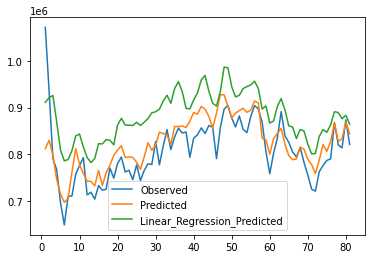

In [ ]:
plt.plot(lr_test.reset_index().groupby("index").sum(),label="Observed")
plt.plot(tft_df.reset_index().groupby("index").sum(),label="Predicted")
plt.plot(lr_df.reset_index().groupby("index").sum(),label="Linear_Regression_Predicted")
plt.legend()


In [ ]:
Observed.to_csv("/content/drive/Shareddrives/MinneMUDAC/data/Prediction data/Observed.csv")
TFT_Prediction.to_csv("/content/drive/Shareddrives/MinneMUDAC/data/Prediction data/TFT_Prediction.csv")
LR_Predction.to_csv("/content/drive/Shareddrives/MinneMUDAC/data/Prediction data/LR_Predction.csv")